In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date,timedelta

from operator import attrgetter

In [2]:
customers   = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
orders      = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
order_items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw', parse_dates=['shipping_limit_date'])

# Считывание данных при глюках ссылок выше

# customers   = pd.read_csv('olist_customers_dataset.csv')
# orders      = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
# order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])                   

In [3]:
# orders.head()

In [4]:
# 1.
# Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

# Проверяем количество customer_id
customers.customer_id.nunique()

99441

In [5]:
# И customer_unique_id.
# Вывод - у некоторых customer_unique_id было несколько покупок.
# (Видимо на каждую покупку уникальному customer_unique_id присваивается новый customer_id)

customers.customer_unique_id.nunique()

96096

In [6]:
# Посчитаем записи в датафрейме customers
# Получаем 93'099 c одной покупкой, 2745 с двумя и т.д.

df_customers = customers.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_ids'})

df_customers.num_ids.value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
Name: num_ids, dtype: int64

In [7]:
# Склеим таблицы customers и orders по customer_id
# Цель: проверить количество уникальных покупателей, совершивших одну покупку. Заодно выведем статус заказа
# Предположение: уникальному customer_unique_id может присваиваться разный customer_id при новом заказе

df_customers_orders = pd.merge(customers, orders, on='customer_id')
df_customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [8]:
# Получили в общей сложности 93'479 единичных заказов

df_num_orders = df_customers_orders.groupby(['customer_unique_id', 'order_status'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_orders'})

df_num_orders.num_orders.value_counts()

1     93479
2      2592
3       182
4        28
5         9
6         5
7         3
15        1
9         1
Name: num_orders, dtype: int64

In [9]:
# Проверяем статусы единичных заказов.
# Логично вычесть отмененные и недоступные заказы

df_num_orders.query('num_orders == 1') \
    .order_status \
    .value_counts()

delivered      90557
shipped         1093
canceled         608
unavailable      599
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [10]:
# 92'263 заказов доставлены, отправлены или в обработке

93479 - 608 - 608

92263

In [11]:
# 2.
# Сколько заказов в месяц в среднем не доставляется по разным причинам
# (вывести детализацию по причинам)? (5 баллов)

In [12]:
# Создадим колонки месяца и года заказа

orders['month_purchase'] = pd.DatetimeIndex(orders['order_purchase_timestamp']).month
orders['year_purchase'] = pd.DatetimeIndex(orders['order_purchase_timestamp']).year

In [13]:
# Считаем кол-во заказов с разным статусом по месяцам по каждому году

df2 = (orders.groupby(['month_purchase',
                       'year_purchase',
                       'order_status'], as_index=False)
    .agg({'order_id': 'count'})
    .rename(columns={'order_id': 'num_orders'})
    )

df2.head()

,month_purchase,year_purchase,order_status,num_orders
0,1,2017,canceled,3
1,1,2017,delivered,750
2,1,2017,invoiced,12
3,1,2017,processing,9
4,1,2017,shipped,16


In [14]:
# Получаем в среднем каждый месяц:
# 29 заказов недоступно
# 26 отменяется
# обработка / выставление счета / создание и одобрение за недоставленные не считаем

df2.groupby('order_status') \
    .agg({'num_orders': 'mean'}) \
    .sort_values('num_orders', ascending=False)

,num_orders
order_status,
delivered,4194.695652
shipped,48.130435
unavailable,29.000000
canceled,26.041667
processing,15.842105
invoiced,14.952381
created,1.666667
approved,1.000000


In [15]:
# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [16]:
df_orders_goods = pd.merge(order_items, orders, on='order_id')
df_orders_goods.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_purchase,year_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,9,2017
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,4,2017


In [17]:
# Создаем колонку дня недели

df_orders_goods['day_purchase_num'] = df_orders_goods.order_purchase_timestamp.dt.dayofweek
df_orders_goods['day_purchase'] = df_orders_goods.order_purchase_timestamp.dt.day_name()

In [18]:
df_orders_goods.groupby(['product_id', 'day_purchase'], as_index=False) \
    .agg({'order_purchase_timestamp': 'count'}) \
    .rename(columns={'order_purchase_timestamp': 'num_orders'}) \
    .groupby(['product_id', 'day_purchase'], as_index=False) \
    .agg({'num_orders': 'max'}) \
    .sort_values('num_orders', ascending=False)

,product_id,day_purchase,num_orders
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
24013,642369377615febc7fa89e4c8df5110e,Thursday,1
24018,642a40d4d73b4b2604968937de13634a,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1
24025,64315bd8c0c47303179dd2e25b579d00,Saturday,1


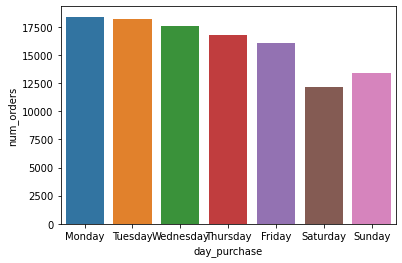

In [19]:
# Чаще всего заказывают в понедельник и вторник
# Самые существенные просадки - суббота и воскресенье
# Если есть желание подтянуть кол-во покупок в конце недели - есть смысл подумать над промками в Чт-Пятницу.
# При этом надо проследить, чтобы это не снизило показатели начала недели

df_orders_goods_days = df_orders_goods.groupby(['day_purchase_num', 'day_purchase'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'num_orders'}) \
    .sort_values('day_purchase_num')

ax = sns.barplot(x="day_purchase", y="num_orders", data=df_orders_goods_days)

In [20]:
# 4.
# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
# Не стоит забывать, что внутри месяца может быть не целое количество недель.
# Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 


In [21]:
# Создаем колонки недели, а также месяца и года для избежания повторных значений недель для разных M/Y

df_customers_orders['week'] = df_customers_orders.order_purchase_timestamp.dt.isocalendar().week
df_customers_orders['month'] = df_customers_orders.order_purchase_timestamp.dt.month
df_customers_orders['year'] = df_customers_orders.order_purchase_timestamp.dt.year
df_customers_orders['avg_weeks'] = df_customers_orders.order_purchase_timestamp.dt.daysinmonth / 7

In [22]:
df_orders_monthly = df_customers_orders.groupby(['customer_unique_id', 'year', 'month', 'avg_weeks'], as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'num_orders_total'}) \
    .sort_values('num_orders_total', ascending=False)

In [23]:
df_orders_monthly['avg_weekly_orders'] = df_orders_monthly.num_orders_total / df_orders_monthly.avg_weeks
df_orders_monthly.head()


,customer_unique_id,year,month,avg_weeks,num_orders_total,avg_weekly_orders
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017,1,4.428571,6,1.354839
50622,83e7958a94bd7f74a9414d8782f87628,2017,1,4.428571,4,0.903226
76793,c8460e4251689ba205045f3ea17884a1,2018,8,4.428571,4,0.903226
67755,b08fab27d47a1eb6deda07bfd965ad43,2017,9,4.285714,4,0.933333
62196,a239b8e2fbce33780f1f1912e2ee5275,2017,2,4.000000,4,1.000000


In [24]:
# При желании можно подтянуть календарь и посчитать реальные количества недель в месяцах
# (например февраль 2022 - 4 недели + 1 понедельник = 5 недель)
# Дайте знать, если это действительно необходимо

# https://stackoverflow.com/questions/25249033/week-of-a-month-pandas

# import datetime
# import calendar

# def week_of_month(tgtdate):
#     tgtdate = tgtdate.to_datetime()

#     days_this_month = calendar.mdays[tgtdate.month]
#     for i in range(1, days_this_month):
#         d = datetime.datetime(tgtdate.year, tgtdate.month, i)
#         if d.day - d.weekday() > 0:
#             startdate = d
#             break
#     # now we canuse the modulo 7 appraoch
#     return (tgtdate - startdate).days //7 + 1

# data['calendar_wom'] = data[0].apply(week_of_month)

In [25]:
# 5. Напиши функцию на python, позволяющую строить когортный анализ.
# В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. (10 баллов)

In [26]:
num_orders = df_customers_orders.groupby(['customer_unique_id', 'month', 'year'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_orders'}) \
    .num_orders

In [27]:
df_customers_orders['cohort'] = df_customers_orders.groupby(['customer_unique_id', 'month', 'year'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_orders'}) \
    .num_orders

In [28]:
df = df_customers_orders[['customer_unique_id', 'order_id', 'order_purchase_timestamp']].drop_duplicates()

In [29]:
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')
df['cohort'] = df.groupby('customer_unique_id')['order_purchase_timestamp'] \
                .transform('min') \
                .dt.to_period('M')

In [30]:
df_cohort = df.groupby(['cohort', 'order_month']) \
                .agg(n_cutomers=('customer_unique_id', 'nunique')) \
                .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [31]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                    columns = 'period_number',
                                    values = 'n_cutomers')

In [32]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [33]:
ur_style = (retention_matrix
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.31%,,,0.31%,,0.31%,,0.31%,,0.31%,,0.31%,0.62%,0.62%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


In [34]:
# Получили лучшую когорту июнь 2017
# Май и март 2017 тоже неплохи (относительно), но в целом показатели везде не айс.. :(

In [35]:
# 6. Построй RFM-кластеры для пользователей.
# Выведи для каждого кластера средние значения метрик R, F, M
# (и опиши подробно, как были построены метрики R, F, M).

In [36]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [37]:
df_customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,week,month,year,avg_weeks,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,20,5,2017,4.428571,1.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2,1,2018,4.428571,1.0


In [38]:
big_df = pd.merge(df_customers_orders, order_items, on='order_id').drop_duplicates()
big_df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,month,year,avg_weeks,cohort,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,5,2017,4.428571,1.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,1,2018,4.428571,1.0,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48


In [39]:
big_df['order_purchase_timestamp'] = big_df['order_purchase_timestamp'].dt.date

In [40]:
big_df = big_df.groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
                .agg({'price': 'sum'}) \
                .rename(columns={'price': 'order_value',
                                'order_purchase_timestamp': 'order_date',
                                'customer_unique_id': 'user_id'})
big_df.head(2)

,user_id,order_date,order_value
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.9


In [41]:
big_df = big_df.iloc[:, [1,0,2]]
big_df

,order_date,user_id,order_value
0,2018-05-10,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,2018-05-07,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,2017-03-10,0000f46a3911fa3c0805444483337064,69.00
3,2017-10-12,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,2017-11-14,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...,...
97724,2017-06-08,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
97725,2017-12-10,fffea47cd6d3cc0a88bd621562a9d061,64.89
97726,2017-02-07,ffff371b4d645b6ecea244b27531430a,89.90
97727,2018-05-02,ffff5962728ec6157033ef9805bacc48,115.00


In [42]:
last_date = big_df['order_date'].max() + timedelta(days=1)
rfmTable = big_df.reset_index().groupby('user_id').agg({'order_date': lambda x: (last_date - x.max()).days,
                                                 'user_id': lambda x: len(x), 
                                                 'order_value': lambda x: x.sum()})
rfmTable.rename(columns={'order_date': 'recency', 
                          'user_id': 'frequency', 
                          'order_value': 'monetary_value'}, inplace=True)

rfmTable.head()

,recency,frequency,monetary_value
user_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
0000f46a3911fa3c0805444483337064,543,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
0004aac84e0df4da2b147fca70cf8255,294,1,180.00


In [43]:
quantiles = rfmTable.quantile(q=[0.33, 0.66])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

def RScore(x,p,d):
     if x <= d[p][0.33]:
         return 1
     elif x <= d[p][0.66]:
         return 2
     else:
         return 3

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(RScore, args=('monetary_value',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
print(segmented_rfm.head())

                                  recency  frequency  monetary_value  \
user_id                                                                
0000366f3b9a7992bf8c76cfdf3221e2      117          1          129.90   
0000b849f77a49e4a4ce2b2a4ca5be3f      120          1           18.90   
0000f46a3911fa3c0805444483337064      543          1           69.00   
0000f6ccb0745a6a4b88665a16c9f078      327          1           25.99   
0004aac84e0df4da2b147fca70cf8255      294          1          180.00   

                                  r_quartile  f_quartile  m_quartile RFMScore  
user_id                                                                        
0000366f3b9a7992bf8c76cfdf3221e2           1           1           3      113  
0000b849f77a49e4a4ce2b2a4ca5be3f           1           1           1      111  
0000f46a3911fa3c0805444483337064           3           1           2      312  
0000f6ccb0745a6a4b88665a16c9f078           3           1           1      311  
0004aac84e0df4d

In [44]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
user_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,1,1,3,113
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,1,1,1,111
0000f46a3911fa3c0805444483337064,543,1,69.00,3,1,2,312
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,3,1,1,311
0004aac84e0df4da2b147fca70cf8255,294,1,180.00,3,1,3,313


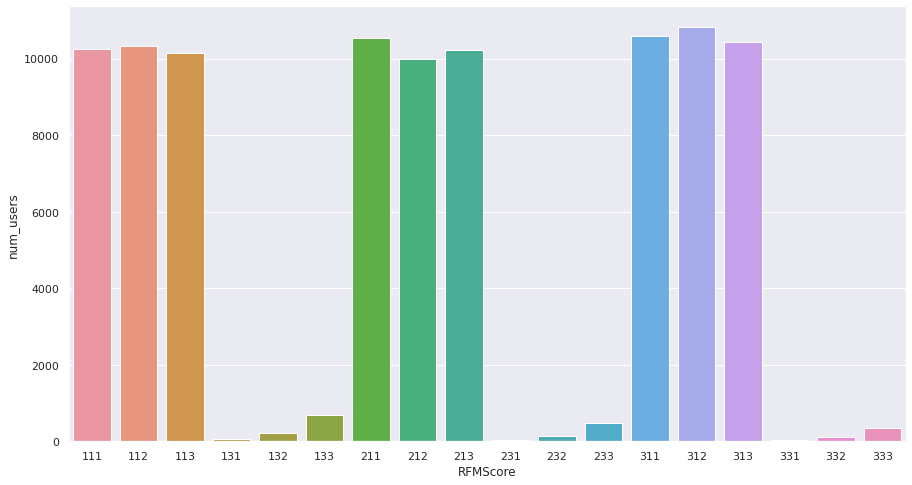

In [45]:
num_users = segmented_rfm.groupby(['RFMScore', 'r_quartile', 'f_quartile', 'm_quartile'], as_index=False) \
    .agg({'monetary_value': 'count'}) \
    .rename(columns={'monetary_value': 'num_users'})

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='RFMScore', y='num_users', data=num_users)

In [46]:
segmented_rfm.RFMScore.value_counts()

312    10825
311    10593
211    10535
313    10445
112    10331
111    10241
213    10225
113    10161
212     9979
133      684
233      480
333      342
132      217
232      139
332      102
131       51
231       36
331       34
Name: RFMScore, dtype: int64

In [47]:
segmented_rfm.describe()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
count,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000
mean,244.501457,1.024198,142.440198,2.006875,1.043702,2.008877
std,153.160850,0.178936,217.656355,0.819116,0.292394,0.817823
min,1.000000,1.000000,0.850000,1.000000,1.000000,1.000000
25%,120.000000,1.000000,47.900000,1.000000,1.000000,1.000000
50%,225.000000,1.000000,89.900000,2.000000,1.000000,2.000000
75%,354.000000,1.000000,155.000000,3.000000,1.000000,3.000000
max,730.000000,16.000000,13440.000000,3.000000,3.000000,3.000000


In [48]:
# RFM анализ представляем собой определение:
# давности (recency). 1-недавно 3-давно
# частотности (frequency). 1-редкие заказы 3-частые
# кол-ва денег (monetary) 1-заказы на меньшую сумму 3-заплатившие много (в нашем случае, относительно :)

# В нашем случае мы разделили все данные на 3 категории по дате/количеству заказов/сумме денег в каждой из них
# При желании можно указывать другие диапазоны, при наличии целевой суммы, полученной от пользователя,
# или частотности его заказов (например, каждый месяц).

# У нас средние значения после разбивки составили
# 225 дней
# 1 заказ за все время
# 89.9 денег

# После получения индексов RFM можно работать как над изменением конкретного параметра (увеличении частоты заказов или суммы заказов),
# так и над целыми кластерами.
# К примеру:
# Пользователи с индексом 133 заказали недавно, часто и на дорого :D $$$ - можно их поощрять за это и показывать любовь нашей компании.
# Таких в наших данных увы немного - 684 юзера

# 313 пользователи заказавшие давно и редко, но принесшие много денег :D
# В данных их получилось 10000, есть смысл поработать над попыткой увеличить частоту их заказов

# Далее можно вырабатывать стратегии по удержанию счастливых пользователей, увеличению счастья неактивных и стимулированию серединчатых